## LOAD LIBRARIES

In [1]:
import pandas as pd
import json
import os
import networkx as nx
import tweepy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import string
import powerlaw
import math
import statistics
import itertools
%matplotlib inline
sns.set_theme(style="ticks")
base_path = "network/"

def graph_statistics(graph, need_plot=True):
    print("NODES:", len(graph.nodes))
    print("EDGES:", len(graph.edges))
    print("DENSITY: {:0.2}".format(nx.density(graph)))
    print("CONNECTED COMPONENTS:", nx.number_connected_components(graph))
    print("MAX CONNECTED COMPONENTS: ", max([len(x) for x in nx.connected_components(graph)]))
    print("CLUSTERING: {:0.2}".format(nx.average_clustering(graph)))
    print("MEAN WEIGHT: {:0.2}".format(sum([x[2]["weight"] for x in graph.edges(data=True)]) / len(graph.edges)))
    if need_plot:
        plt.figure(figsize=(12,8))
        plt.title("CONNECTED COMPONENT DIMENSIONS")
        sns.histplot([len(x) for x in nx.connected_components(graph)], bins=100)
    
def centrality(graph, k=10, adjust=False, title=""):
    degree = {k: graph.degree(k) for k in graph.nodes}
    degree = {k: v for k, v in sorted(degree.items(), key=lambda item: item[1], reverse=True)}
    print("TOP USERS BY DEGREE")
    top_degree = list(degree.keys())[:k]
#     print(top_degree)
        
    fig = plt.figure(figsize=(12,8))
    fig = format_graph(fig, x_label="Degree centrality", title=title)
    dis = np.histogram(list(degree.values()), bins=max(list(degree.values())))
    dis = dict(zip(dis[1], dis[0] + 1))
    dis = {k: v for k, v in sorted(dis.items(), key=lambda item: item[1], reverse=True) if k > 0}
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    sns.scatterplot(x = dis.keys(), y = dis.values())
    plt.xscale('symlog')
    plt.yscale('symlog')

    print("DEGREE CENTRALITY POWER LAW")
    results = powerlaw.Fit(np.histogram(list(degree.values()), bins=50)[0])
    print("Alpha: ", str(results.power_law.alpha), " Delta: ", str(results.power_law.D))
    return top_degree

def format_graph(fig, x_label, title=""):
    ax = fig.gca()
    ax.set_xlabel(x_label, fontsize=21)
    ax.set_ylabel("Number of users", fontsize=21)
    ax.set_title(title, fontsize=24)
    return fig

def ego(graph, nodes):
    # print("EGO ANALYSIS ON", nodes)
    density = 0
    clustering = 0
    for n in nodes:
      try:
        e = nx.ego_graph(graph, n)
        c = nx.average_clustering(e)
        d = nx.density(e)
        density += d
        clustering += c
        print(n, "nodes", len(e.nodes), "density", round(d, 3), "clustering", round(c, 3))
      except:
        print(n, "not present")
    return {"mean_density": round(density / len(nodes), 3), 
            "mean_clustering": round(clustering / len(nodes), 3)}


## LOAD GRAPHS

In [2]:
retweet_graph = nx.read_gexf(base_path + "retweet.gexf")
reply_graph = nx.read_gexf(base_path + "reply_to.gexf")
edges_list = pd.read_csv(base_path + "network_likes.csv", sep=";").apply(lambda x: 
                                                                         str(x[0]) + " " + str(x[1]) + " {'weight': " + str(x[2]) + "}", axis=1)
likes_graph = nx.parse_edgelist(edges_list)
edges_list = pd.read_csv(base_path + "network_mentions.csv", sep=";").apply(lambda x: 
                                                                         str(x[0]) + " " + str(x[1]) + " {'weight': " + str(x[2]) + "}", axis=1)
mentions_graph = nx.parse_edgelist(edges_list)

retweet_graph.remove_edges_from(nx.selfloop_edges(retweet_graph))
reply_graph.remove_edges_from(nx.selfloop_edges(reply_graph))
likes_graph.remove_edges_from(nx.selfloop_edges(likes_graph))
mentions_graph.remove_edges_from(nx.selfloop_edges(mentions_graph))

# SINGLE LAYER ANALYSIS

In [3]:
# top users to select
top_k = 3000

## RETWEET

NODES: 8736
EDGES: 3429
DENSITY: 9e-05
CONNECTED COMPONENTS: 5690
MAX CONNECTED COMPONENTS:  2128
CLUSTERING: 0.0048
MEAN WEIGHT: 1.1
TOP USERS BY DEGREE
DEGREE CENTRALITY POWER LAW
Calculating best minimal value for power law fit
Alpha:  1.6547146468113743  Delta:  0.10933158115128627


Values less than or equal to 0 in data. Throwing out 0 or negative values


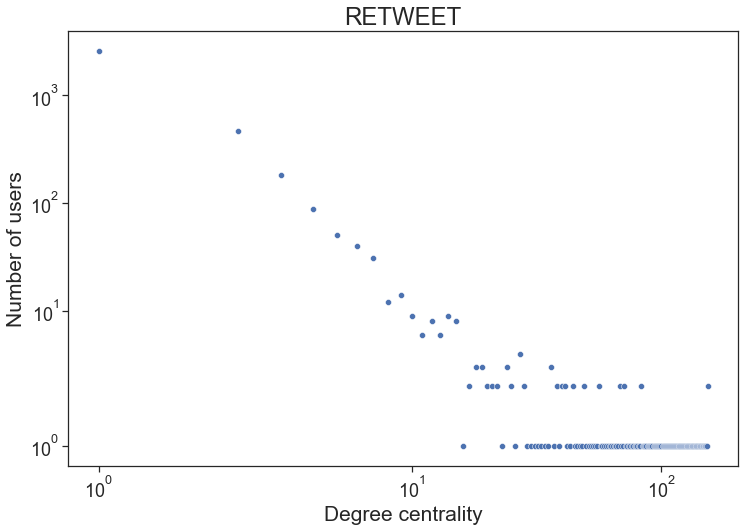

In [4]:
graph_statistics(retweet_graph, need_plot=False)
retweet_degree = centrality(retweet_graph, k = top_k, title="RETWEET")

## REPLY TO

NODES: 8736
EDGES: 354
DENSITY: 9.3e-06
CONNECTED COMPONENTS: 8388
MAX CONNECTED COMPONENTS:  70
CLUSTERING: 0.00061
MEAN WEIGHT: 1.2
TOP USERS BY DEGREE
DEGREE CENTRALITY POWER LAW
Calculating best minimal value for power law fit
Alpha:  1.34833148812152  Delta:  0.10221643355689514


Values less than or equal to 0 in data. Throwing out 0 or negative values


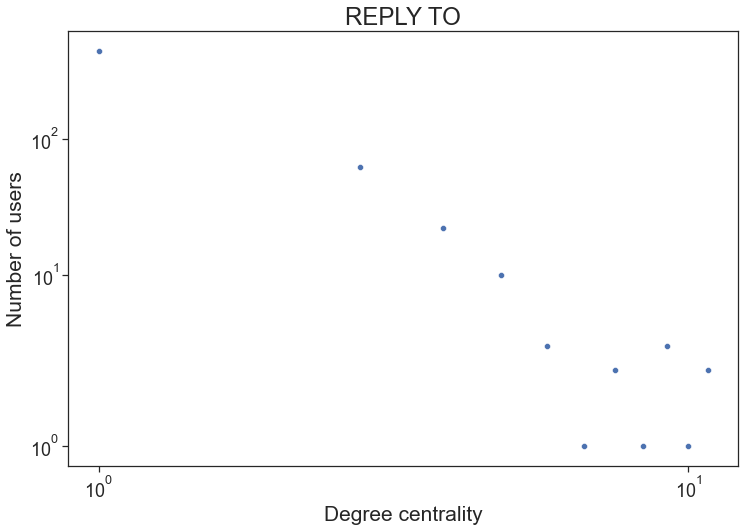

In [5]:
graph_statistics(reply_graph, need_plot=False)
replyto_degree =centrality(reply_graph, k = top_k,title="REPLY TO")

## LIKE

NODES: 835
EDGES: 762
DENSITY: 0.0022
CONNECTED COMPONENTS: 117
MAX CONNECTED COMPONENTS:  501
CLUSTERING: 0.0087
MEAN WEIGHT: 1.1
TOP USERS BY DEGREE
DEGREE CENTRALITY POWER LAW
Calculating best minimal value for power law fit
Alpha:  1.7068996463780262  Delta:  0.1009337893424207


Values less than or equal to 0 in data. Throwing out 0 or negative values


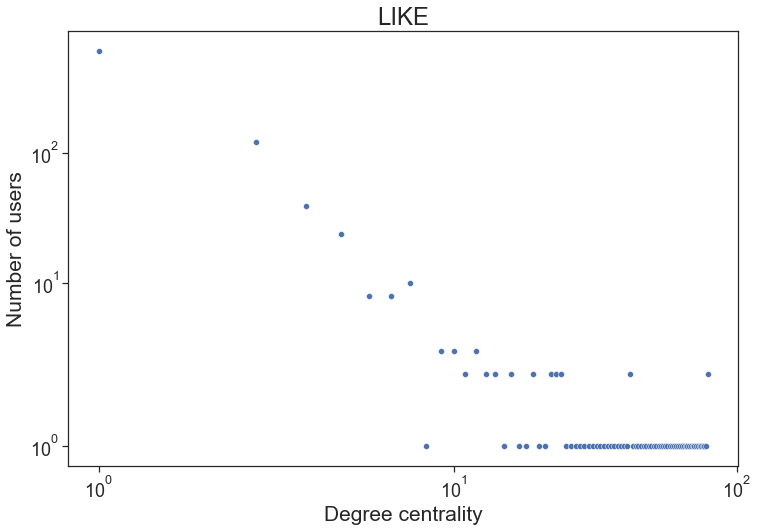

In [6]:
graph_statistics(likes_graph, need_plot=False)
likes_degree =centrality(likes_graph, k = top_k, adjust=True,title="LIKE")

## MENTION

NODES: 4426
EDGES: 4885
DENSITY: 0.0005
CONNECTED COMPONENTS: 590
MAX CONNECTED COMPONENTS:  3047
CLUSTERING: 0.067
MEAN WEIGHT: 1.2
TOP USERS BY DEGREE
DEGREE CENTRALITY POWER LAW
Calculating best minimal value for power law fit
Alpha:  1.5601029093665124  Delta:  0.06562748633093274


Values less than or equal to 0 in data. Throwing out 0 or negative values


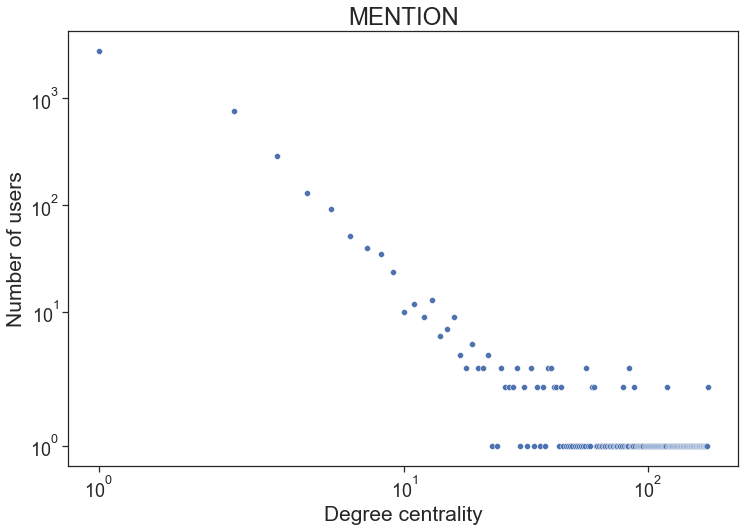

In [7]:
graph_statistics(mentions_graph, need_plot=False)
mentions_degree =centrality(mentions_graph, k = top_k, adjust=True,title="MENTION")

## INTERSECTION BY CENTRALITY

In [8]:
# without like relationship
top_users_nolike= set(retweet_degree).intersection(replyto_degree).intersection(mentions_degree)
len(top_users_nolike)

894

In [9]:
# with like relationship
top_users_like= set(retweet_degree).intersection(replyto_degree).intersection(mentions_degree).intersection(likes_degree)
len(top_users_like)

163

## EGO NETWORK ANALYSIS

EGO ANALYSIS ON RETWEET
       density  clustering   n_nodes
mean  0.796244    0.029179  3.904922
std   0.276228    0.133514  7.731997
EGO ANALYSIS ON REPLY TO
       density  clustering   n_nodes
mean  0.219223    0.005157  1.394855
std   0.394777    0.061753  0.962695
EGO ANALYSIS ON LIKE
       density  clustering   n_nodes
mean  0.147186    0.006844  0.694631
std   0.333625    0.071676  3.265352
EGO ANALYSIS ON MENTION
       density  clustering   n_nodes
mean  0.719708    0.152575  5.057047
std   0.291758    0.298237  9.512536


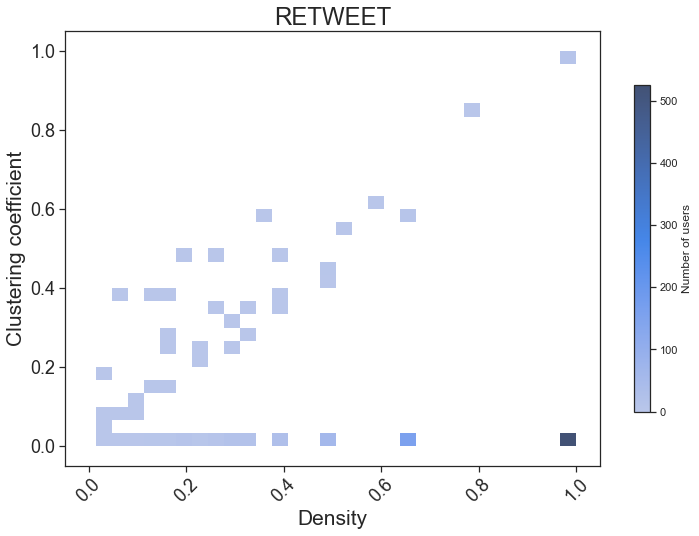

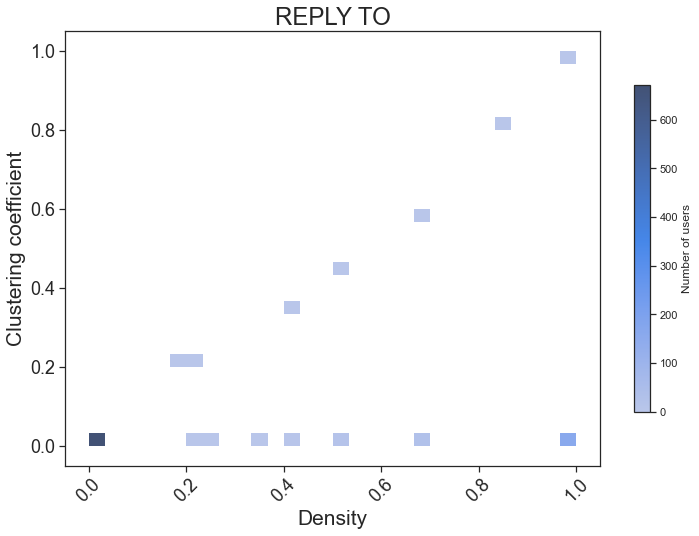

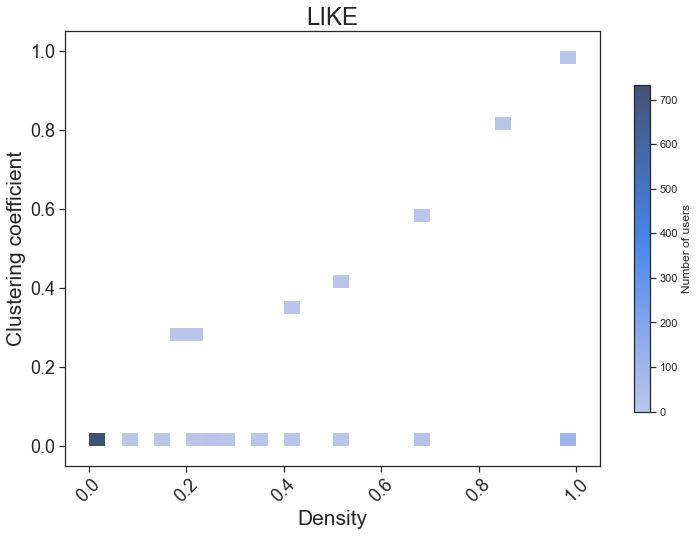

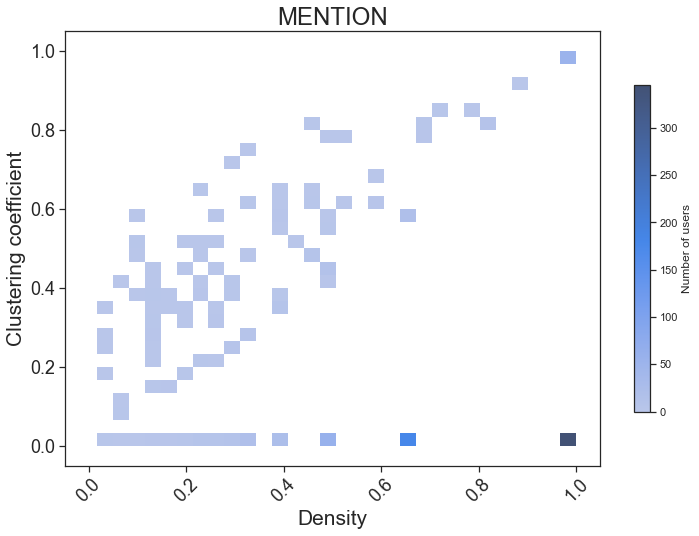

In [10]:
def ego(graph, nodes, graph_title):
    print("EGO ANALYSIS ON", graph_title)
    user = {}
    overlap = {}
    for n in nodes:
        try:
            e = nx.ego_graph(graph, n)
            c = nx.average_clustering(e)
            d = nx.density(e)
            overlap[n] = (len(set(e.nodes).intersection(nodes)) - 1) / len(nodes) 
            user[n] = {"density": d, "clustering": c, "n_nodes": len(e.nodes)}
        except Exception as e:
            user[n] = {"density": 0, "clustering": 0, "n_nodes": 0}
            overlap[n] = 0
            
    # density and clustering plot
    fig = plt.figure(figsize=(12, 8))
    df = pd.DataFrame(user).T
    sns.histplot(x="density", y="clustering", data=df, label="Verified user",
                    color="cornflowerblue", bins=30, cbar=True, cbar_kws=dict(shrink=.75, label="Number of users"))
    ax = fig.gca()
    ax.set_title(graph_title, fontsize=24)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    ax.set_xlabel("Density", fontsize=21)
    ax.set_ylabel("Clustering coefficient", fontsize=21)
    ax.set_xlim((-0.05, 1.05))
    ax.set_ylim((-0.05, 1.05))
    
    print(df.describe()[["density", "clustering", "n_nodes"]].iloc[1:3])


ego_users = top_users_nolike
 
ego(retweet_graph, ego_users, "RETWEET")
ego(reply_graph, ego_users, "REPLY TO")
ego(likes_graph, ego_users, "LIKE")
ego(mentions_graph, ego_users, "MENTION")

# MULTILAYER APPROACH

### USER MULTILAYER DEGREE AND TOP PLAYERS

In [11]:
multi_degree = {}
graphs = [retweet_graph, reply_graph, likes_graph, mentions_graph]
all_users = set(retweet_graph.nodes).union(reply_graph.nodes).union(likes_graph.nodes).union(mentions_graph.nodes)
centralities = {
          "retweet": {k: retweet_graph.degree(k) for k in retweet_graph.nodes},
          "replyto": {k: reply_graph.degree(k) for k in reply_graph.nodes},
          "like":{k: likes_graph.degree(k) for k in likes_graph.nodes},
          "mention": {k: mentions_graph.degree(k) for k in mentions_graph.nodes}
        }

ego_multilayer = {}
for user in all_users:
  if user:
    multi_degree[user] = []
    for c in centralities:
      if user in centralities[c]:
        multi_degree[user].append(centralities[c][user])
      else:
        multi_degree[user].append(0)
    multi_degree[user] = statistics.mean(multi_degree[user])
    # multilayer ego
    ego_net = nx.Graph()
    for g in graphs:
      if user in list(g.nodes):
        other_ego = nx.ego_graph(g, user)
        ego_net = nx.compose(ego_net, other_ego)
        ego_net.remove_nodes_from(list(nx.isolates(ego_net)))
        # print(len(ego_net.nodes), len(ego_net.edges), 
        #       len(other_ego.nodes), len(other_ego.edges))
    ego_multilayer[user] = ego_net

In [12]:
# extract multilayer top users
multi_top = {k: v for k, v in sorted(multi_degree.items(), key=lambda item: item[1], reverse=True)}
print(len(set(list(multi_top.keys())[:67]).intersection(top_users_like)))
print(len(set(list(multi_top.keys())[:143]).intersection(top_users_nolike)))
multi_top_143 = list(multi_top.keys())[:143]
multi_top_67 = list(multi_top.keys())[:67]

21
82


## PLOT THE MULTILAYER NETWORK CENTRALITY

Calculating best minimal value for power law fit
DEGREE CENTRALITY POWER LAW
Alpha:  2.6140006855292413  Delta:  0.040815927999150126


Values less than or equal to 0 in data. Throwing out 0 or negative values


Text(0, 0.5, 'Number of users')

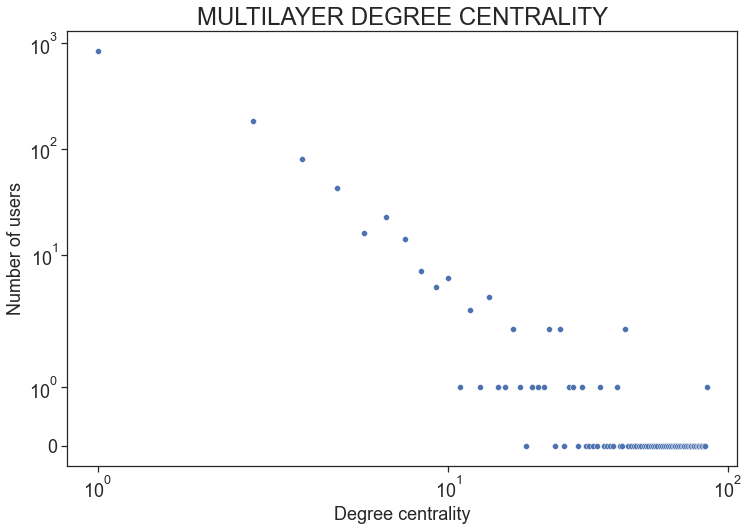

In [13]:
results = powerlaw.Fit(list(multi_degree.values()))
print("DEGREE CENTRALITY POWER LAW")
print("Alpha: ", str(results.power_law.alpha), " Delta: ", str(results.power_law.D))


dis = np.histogram(list(multi_degree.values()), bins=max(list(multi_degree.values())))
dis = dict(zip(dis[1], dis[0]))
dis = {k: v for k, v in sorted(dis.items(), key=lambda item: item[1], reverse=True) if k > 0}

fig = plt.figure(figsize=(12,8))
plt.xscale('symlog')
plt.yscale('symlog')
sns.scatterplot(x = dis.keys(), y = dis.values())
plt.title("MULTILAYER DEGREE CENTRALITY", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Degree centrality", fontsize=18)
plt.ylabel("Number of users", fontsize=18)

## EGO MULTILAYER

In [14]:
threshold = 1
info = []
for user in multi_top_143:
  if len(ego_multilayer[user].nodes) > threshold:  
    weights = ego_multilayer[user].edges(data=True)
    weights = [x[2]["weight"] for x in weights]
    info.append([
              #  nx.density(ego_multilayer[user]),
              #  nx.average_clustering(ego_multilayer[user]),
              len(ego_multilayer[user].nodes),
              len(ego_multilayer[user].edges),
              sum(weights)
    ])

stat_multi = pd.DataFrame(info, columns=["nodes", "edges", "interactions"])
stat_multi["label"] = "Multilayer Network"
print(stat_multi.describe().round(2))


info = []
for user in top_users_nolike:
  if len(ego_multilayer[user].nodes) > threshold:
    weights = ego_multilayer[user].edges(data=True)
    weights = [x[2]["weight"] for x in weights]
    info.append([
              #  nx.density(ego_multilayer[user]),
              #  nx.average_clustering(ego_multilayer[user]),
              len(ego_multilayer[user].nodes),
              len(ego_multilayer[user].edges),
              sum(weights)
    ])
stat_single = pd.DataFrame(info, columns=["nodes", "edges", "interactions"])
stat_single["label"] = "Single Layer Network"

print(stat_single.describe().round(2))

        nodes   edges  interactions
count  143.00  143.00        143.00
mean    23.41   28.84         68.05
std     23.23   33.99        134.09
min      7.00    6.00          6.00
25%     11.50   13.00         14.00
50%     16.00   18.00         21.00
75%     23.00   28.50         34.50
max    178.00  245.00        824.00
        nodes   edges  interactions
count  894.00  894.00        894.00
mean     5.41    5.49         13.01
std     10.26   14.58         57.14
min      2.00    1.00          1.00
25%      2.00    1.00          1.00
50%      3.00    2.00          2.00
75%      5.00    5.00          5.00
max    178.00  245.00        824.00


## ANALYZE TOPICS DISCUSSED BY TOP USERS

In [15]:
# hashtag by classes (you can see some examples)
novax = {'billgatesvaccine', 'medicalfascism', 'covidiots', 'vaccinefraud', 'notosavinglives', 'antivacc', 'nomandatoryvacccines', 'billgatesbioterror', 'coronavirusfrauds', 'antivaxxers', 'billgatesbioterrorist', 'antivaccine', 'novaccinemandates', 'covidvaccinefails', 'freedomoverfear', 'novaccineforme', 'antivax', 'notovaccines', 'masksdontwork', 'vaccinefailure', 'notomaskwashdistance', 'exposebillgates', 'researchanddestroy', 'freedomfrommedicaltyranny', 'bigpharma', 'unvaccinated', 'novaccine', 'exposebillgate'}
neural = {'coronavirusupdates', 'vaccines', 'corona', 'covi', 'covid19pandemic', 'coronavirusvaccine', 'covid', 'covidvaccine', 'lockdown2021', 'covidrules', 'astrazeneca', 'covidsecondwave', 'vaccination', 'covid19vaccine', 'coronav', 'coronaviruswales', 'covid19', 'coronavirus', 'covidrelief', 'vaccine', 'hospital', 'covidlife', 'immune', 'variantsofconcern', 'coronavaccine', 'covid19vaccination', 'covid_19'}
provax = {'vaccinessavelives', 'vaxxing', 'igotmyshot', 'vaccineswork', 'vaxxednow', 'vaxxed', 'wearmaskprotectlife', 'vaxxie', 'vaccinated', 'maskuptx', 'vaccinationrules', 'phuckcovid', 'vaccinateeducatorsnow', 'getvaccinated', 'indiafightscorona', 'vaccineequity', 'vaccinateny', 'wearamask', 'maskup'}

In [16]:
tweets = json.load(open("dataset/verified_tweets.txt", "r"))
df = pd.DataFrame.from_records(tweets)
df["screen_name"] = df["user"].apply(lambda x: x["screen_name"])
df["hashtags"] = df["entities"].apply(lambda x: [y["text"] for y in x["hashtags"]])

In [17]:
multi_top_keywords = {}
single_top_keywords = {}

for user in top_users_nolike:
    user_tweets = df.loc[df["screen_name"] == user].full_text.values
    words = [x.split(" ") for x in user_tweets]
    words = [y.translate(str.maketrans('', '', string.punctuation)).lower() for x in words for y in x]
    # words = [y.lower() for x in df.loc[df["screen_name"] == user]["hashtags"].to_list() for y in x]
    single_top_keywords[user] = {"pro-vax": len(set(words).intersection(provax)),
                    "anti-vax": len(set(words).intersection(novax)),
                    "neutral": len(set(words).intersection(neutral))}
single_top_keywords = pd.DataFrame(single_top_keywords).T
single_top_keywords["label"] = "Single Networks"

for user in multi_top_143:
    user_tweets = df.loc[df["screen_name"] == user].full_text.values
    words = [x.split(" ") for x in user_tweets]
    words = [y.translate(str.maketrans('', '', string.punctuation)).lower() for x in words for y in x]
    # words = [y.lower() for x in df.loc[df["screen_name"] == user]["hashtags"].to_list() for y in x]
    multi_top_keywords[user] = {"pro-vax": len(set(words).intersection(provax)),
                    "anti-vax": len(set(words).intersection(novax)),
                    "neutral": len(set(words).intersection(neutral))}
multi_top_keywords = pd.DataFrame(multi_top_keywords).T
multi_top_keywords["label"] = "Multilayer Network"
keywords = pd.concat([multi_top_keywords, single_top_keywords]).groupby("label").sum().reset_index()
keywords = keywords.melt(id_vars=["label"], value_vars=["pro-vax", "neutral", "anti-vax"])#.T.reset_index()

NameError: name 'neutral' is not defined

In [ ]:
clrs = ["#386fc2", "#83AFF2"]

fig = plt.figure(figsize=(12, 8))
sns.barplot(x="variable", y="value", hue="label", data=keywords, palette=clrs)
ax = fig.gca()
ax.set_title("TOPIC DISTRIBUTION IN USER TWEETS", fontsize=24)
ax.set_xlabel("Topic", fontsize=21)
ax.set_ylabel("Hashtags occurrences", fontsize=21)
plt.xticks(fontsize=16)
plt.legend(title="", loc="best")

## TOPIC-USER PROJECTION

In [ ]:
proj_retweet = nx.Graph()
proj_like = nx.Graph()
proj_mention = nx.Graph()
proj_reply = nx.Graph()
users = [x.split(",")[0] for x in open("dataset/verified_users.txt", "r").read().split("\n")]
proj_retweet.add_nodes_from(users)
proj_like.add_nodes_from(users)
proj_mention.add_nodes_from(users)
proj_reply.add_nodes_from(users)

In [ ]:
tweets = json.load(open("dataset/verified_tweets.txt", "r"))
df = pd.DataFrame.from_records(tweets)
df["screen_name"] = df["user"].apply(lambda x: x["screen_name"])
df["hashtags"] = df["entities"].apply(lambda x: [y["text"] for y in x["hashtags"]])
df["full_text"] = df["full_text"].apply(lambda x: x.replace("“", "").replace("”", "").split(" "))
df["full_text"] = df["full_text"].apply(lambda x: [y.translate(str.maketrans('', '', string.punctuation)).lower() for y in x])
df["retweet_screen_name"] = df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if not isinstance(x, float) else "None")

likes_df = pd.read_csv("dataset/likes.csv")
likes_df["TweetText"] = likes_df["TweetText"].apply(lambda x: x.replace("“", "").replace("”", "").split(" "))
likes_df["TweetText"] = likes_df["TweetText"].apply(lambda x: [y.translate(str.maketrans('', '', string.punctuation)).lower() for y in x])

In [ ]:
# run for each projection to generate the all the networks
projection = "neutral"
keywords = {"pro-vax": provax, "anti-vax": novax, "neutral": neutral}

for user in users:
    user_tweets = df.loc[df["screen_name"] == user].copy(deep=True)
    user_tweets["fine"] = user_tweets["full_text"].apply(lambda x: len(set(x).intersection(keywords[projection])) > 0)
    user_tweets = user_tweets.loc[user_tweets["fine"] == True]
    if len(user_tweets) > 0:
        # replyto graph
        for _, t in user_tweets.iterrows():
            if t["in_reply_to_screen_name"] in proj_reply.nodes:
                a, b = t["user"]["screen_name"], t["in_reply_to_screen_name"]
                if proj_reply.has_edge(a, b) or proj_reply.has_edge(b, a):
                    proj_reply[a][b]["weight"] = proj_reply[a][b]["weight"] + 1
                else:
                    proj_reply.add_edge(a, b, weight=1)

        # retweet graph
        for _, t in user_tweets.iterrows():
            a, b = t["screen_name"], t["retweet_screen_name"]
            if a in proj_retweet.nodes and b in proj_retweet.nodes:
                if proj_retweet.has_edge(a, b) or proj_retweet.has_edge(b, a):
                    proj_retweet[a][b]["weight"] = proj_retweet[a][b]["weight"] + 1
                else:
                    proj_retweet.add_edge(a, b, weight=1)

        # mention graph
        for _, t in user_tweets.iterrows():
            user_mentions = t["entities"]['user_mentions']
            mentions = [mention["screen_name"] for mention in user_mentions if mention["screen_name"] in users]
            a = t["screen_name"]
            for b in mentions:
                if a in proj_retweet.nodes and b in proj_retweet.nodes:
                    if proj_mention.has_edge(a, b) or proj_mention.has_edge(b, a):
                        proj_mention[a][b]["weight"] = proj_mention[a][b]["weight"] + 1
                    else:
                        proj_mention.add_edge(a, b, weight=1)

        # like graph
        like_user = likes_df.loc[likes_df["UsernameAutore"] == user].copy(deep=True)
        like_user["fine"] = like_user["TweetText"].apply(lambda x: len(set(x).intersection(keywords[projection])) > 0)
        like_user = like_user.loc[like_user["fine"] == True]
        if len(like_user) > 0:
            for _, t in like_user.iterrows():
                a, b = t["UsernameAutore"], t["UsernameUtenteLike"]
                if a in proj_retweet.nodes and b in proj_retweet.nodes:
                    if proj_like.has_edge(a, b) or proj_like.has_edge(b, a):
                        proj_like[a][b]["weight"] = proj_like[a][b]["weight"] + 1
                    else:
                        proj_like.add_edge(a, b, weight=1)


proj_retweet.remove_edges_from(nx.selfloop_edges(proj_retweet))
proj_reply.remove_edges_from(nx.selfloop_edges(proj_reply))
proj_like.remove_edges_from(nx.selfloop_edges(proj_like))
proj_mention.remove_edges_from(nx.selfloop_edges(proj_mention))

nx.write_gexf(proj_retweet, base_path + "proj-retweet-" + projection + ".gexf")
nx.write_gexf(proj_reply, base_path + "proj-reply-" + projection + ".gexf")
nx.write_gexf(proj_like, base_path + "proj-like-" + projection + ".gexf")
nx.write_gexf(proj_mention, base_path + "proj-mention-" + projection + ".gexf")

In [ ]:
print("-" * 20,"\nRETWEET")
graph_statistics(proj_retweet, need_plot=False)
print("-" * 20,"\nREPLY")
graph_statistics(proj_reply,need_plot=False)
print("-" * 20,"\nLIKE")
graph_statistics(proj_like,need_plot=False)
print("-" * 20,"\nMENTION")
graph_statistics(proj_mention,need_plot=False)

## ANALYSIS OF NETWORK PROJECTIONS

In [ ]:
topics = ["pro-vax", "neutral", "anti-vax"]
networks = ["retweet", "reply", "like", "mention"]
proj_graph = {k: {} for k in networks}
base_url =  "network/proj-"
stat = {k: {} for k in networks}
for topic in topics:
  for net in networks:
    proj_graph[net][topic] = nx.read_gexf(base_url + net + "-" + topic + ".gexf")
    proj_graph[net][topic].remove_nodes_from(list(nx.isolates(proj_graph[net][topic])))
    stat[net][topic] = {"Nodes": len(proj_graph[net][topic].nodes),
                        "Edges": len(proj_graph[net][topic].edges),
                        "clustering coeff.": nx.average_clustering(proj_graph[net][topic]),
                        "weight": sum([x[2]["weight"] for x in proj_graph[net][topic].edges(data=True)]) / len(proj_graph[net][topic].edges)}

In [ ]:
colors = ["#38705E", "#81FCD3", "#08A873"]
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

for i in range(len(networks)):
    net = networks[i]
    s = pd.DataFrame(stat[net]).T.reset_index().melt(id_vars=["index"], value_vars=["Nodes", "Edges"])
    x, y = int((i) / 2), (i) % 2 
    sns.barplot(x="variable", y="value", hue="index", data=s, ax=ax[x, y], palette=colors)
    if net.upper() == "REPLY":
        ax[x, y].set_title("REPLY TO", fontsize=24)
    else:
        ax[x, y].set_title(net.upper(), fontsize=24)
    ax[x, y].set_xlabel("Network features", fontsize=21)
    ax[x, y].set_ylabel("Number of Nodes / Edges", fontsize=21)
    ax[x, y].tick_params(axis='both', which='major', labelsize=18)
    ax[x, y].get_legend().remove()

  # ax[x, y].set_yticks(fontsize=18)
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(title="", handles=handles,labels=labels, loc="upper center", ncol=3,
           fontsize=18, frameon=False)
plt.subplots_adjust(hspace = .3)

### ANALYZE INTERSECTIONS OF TOP USERS

In [ ]:
multi_degree = {k: {} for k in topics}
for topic in topics:
    centralities = {}
    all_users = []
    for net in networks:
        centralities[net] = {k: proj_graph[net][topic].degree(k) for k in proj_graph[net][topic].nodes}
        all_users = all_users + list(centralities[net].keys())
    all_users = list(set(all_users))
    topic_degree = {}
    for user in all_users:
        if user:
            topic_degree[user] = []
            for c in centralities:
                if user in centralities[c]:
                    topic_degree[user].append(centralities[c][user])
                else:
                    topic_degree[user].append(0)
            topic_degree[user] = statistics.mean(topic_degree[user])
    multi_degree[topic] = {k: v for k, v in sorted(topic_degree.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
# top intersection
print(list(multi_degree["pro-vax"].keys())[:10])
print(list(multi_degree["anti-vax"].keys())[:10])
print(list(multi_degree["neutral"].keys())[:10])

In [ ]:
ns = [100, 200, 500, 800]
heatmap = {}
for n in ns:
    k = "Top-" + str(n) + " users"
    heatmap[k] = {}
    heatmap[k]["Common anti-vax and pro-vax"] = len(set(list(multi_degree["pro-vax"].keys())[:n]).intersection(list(multi_degree["anti-vax"].keys())[:n])) / n * 100
    heatmap[k]["Common anti-vax and neutral"] = len(set(list(multi_degree["neutral"].keys())[:n]).intersection(list(multi_degree["anti-vax"].keys())[:n])) / n * 100
    heatmap[k]["Common neutral and pro-vax"] = len(set(list(multi_degree["pro-vax"].keys())[:n]).intersection(list(multi_degree["neutral"].keys())[:n])) / n * 100

plt.figure(figsize=(12, 8))
ax = sns.heatmap(pd.DataFrame(heatmap), annot=True, cmap="Blues", annot_kws={"size": 14})
plt.tick_params(axis='both', which='major', labelsize=16, labelbottom = False, bottom=False, top = False, labeltop=True)
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

In [ ]:
# study ego networks of the most influential users
top_k = 200 
n = 800
multi_topic_ego = {k: {} for k in topics}
single_topic_ego = {k: {"Density":0, 
                        "Clustering coefficient": 0, 
                        "Nodes": 0, 
                        "Edges": 0, 
                        "Interactions": 0,
                        "Users": 0} for k in topics}
for topic in topics:
  top_users = list(multi_degree[topic].keys())[:n] # multilayer ego network analysis
  # top_users = top_users_nolike # single networks analysis
  for user in top_users:
    ego_net = nx.Graph()
    for net in networks:
      if user in proj_graph[net][topic].nodes:
        other_ego = nx.ego_graph(proj_graph[net][topic], user)
        ego_net = nx.compose(ego_net, other_ego)
        ego_net.remove_nodes_from(list(nx.isolates(ego_net)))
        # update single stats
        single_topic_ego[topic]["Density"] += nx.density(other_ego)
        single_topic_ego[topic]["Clustering coefficient"] += nx.average_clustering(other_ego)
        single_topic_ego[topic]["Nodes"] += len(other_ego.nodes)
        single_topic_ego[topic]["Edges"] += len(other_ego.edges)
        single_topic_ego[topic]["Users"] += 1
        weights = other_ego.edges(data=True)
        weights = [x[2]["weight"] for x in weights]
        single_topic_ego[topic]["Interactions"] += sum(weights)
    multi_topic_ego[topic][user] = ego_net

# take mean of single stats
single_stats = {}
for topic in topics:
  for k, v in single_topic_ego[topic].items():
    if k != "Users":
      single_topic_ego[topic][k] = v / single_topic_ego[topic]["Users"]
  single_stats[topic] = pd.DataFrame.from_dict(single_topic_ego[topic], orient="index").T
  single_stats[topic]["label"] = topic

In [ ]:
# plot single networks ego analysis
colors = ["#38705E", "#81FCD3", "#08A873"]
data = pd.concat([single_stats["pro-vax"], single_stats["neutral"], single_stats["anti-vax"]])
fig = plt.figure(figsize=(12, 8))
plot_data = data.reset_index().melt(id_vars=["label"], value_vars=["Density", "Clustering coefficient"])
sns.barplot(x="variable", y="value", hue="label", data=plot_data, ci=0.05, palette=colors)
ax = fig.gca()
ax.set_title("SINGLE EGO NETWORKS ANALYSIS", fontsize=24)
ax.set_xlabel("Network features", fontsize=21)
ax.set_ylabel("Density / Clustering", fontsize=21)
plt.xticks(fontsize=16)
plt.ylim((0, 1.))
plt.legend(title="", loc="best")

In [ ]:
# plot single networks ego analysis
colors = ["#38705E", "#81FCD3", "#08A873"]
data = pd.concat([single_stats["pro-vax"], single_stats["neutral"], single_stats["anti-vax"]])
fig = plt.figure(figsize=(12, 8))
plot_data = data.reset_index().melt(id_vars=["label"], value_vars=["Nodes", "Edges", "Interactions"])
sns.barplot(x="variable", y="value", hue="label", data=plot_data, ci=0.05, palette=colors)
ax = fig.gca()
ax.set_title("SINGLE EGO NETWORKS ANALYSIS", fontsize=24)
ax.set_xlabel("Network features", fontsize=21)
ax.set_ylabel("Number of Nodes / Edges / Interactions", fontsize=21)
plt.xticks(fontsize=16)
plt.ylim((0, 35))
plt.legend(title="", loc="best")

In [ ]:
# multilayer plot
stats = {k: {} for k in topics}
threshold = 1
for topic in topics:
    info = []
    top_users = list(multi_degree[topic].keys())[:n] # multilayer ego network analysis
    for user in top_users: 
        if user in multi_topic_ego[topic] and len(multi_topic_ego[topic][user].edges) > threshold:
            weights = multi_topic_ego[topic][user].edges(data=True)
            weights = [x[2]["weight"] for x in weights]
            info.append([
                    nx.density(multi_topic_ego[topic][user]),
                    nx.average_clustering(multi_topic_ego[topic][user]),
                    len(multi_topic_ego[topic][user].nodes),
                    len(multi_topic_ego[topic][user].edges),
                    sum(weights)
            ])

    stats[topic] = pd.DataFrame(info, columns=["Density", "Clustering coefficient", "Nodes", "Edges", "Interactions"])

In [ ]:
stats["pro-vax"]["label"] = "pro-vax"
stats["neutral"]["label"] = "neutral"
stats["anti-vax"]["label"] = "anti-vax"
colors = ["#38705E", "#81FCD3", "#08A873"]
data = pd.concat([stats["pro-vax"], stats["neutral"], stats["anti-vax"]])
#data = data.groupby("label").mean().reindex(["provax", "neutral", "novax"])
fig = plt.figure(figsize=(12, 8))
plot_data = data.reset_index().melt(id_vars=["label"], value_vars=["Density", "Clustering coefficient"])
sns.barplot(x="variable", y="value", hue="label", data=plot_data, ci=0.05, palette=colors)
ax = fig.gca()
ax.set_title("MULTILAYER EGO NETWORKS ANALYSIS", fontsize=24)
ax.set_xlabel("Network features", fontsize=21)
ax.set_ylabel("Density / Clustering", fontsize=21)
plt.xticks(fontsize=16)
plt.ylim((0, 1.))
plt.legend(title="", loc="best")

In [ ]:
stats["pro-vax"]["label"] = "pro-vax"
stats["neutral"]["label"] = "neutral"
stats["anti-vax"]["label"] = "anti-vax"

data = pd.concat([stats["pro-vax"], stats["neutral"], stats["anti-vax"]])
#data = data.groupby("label").mean().reindex(["provax", "neutral", "novax"])
fig = plt.figure(figsize=(12, 8))
plot_data = data.reset_index().melt(id_vars=["label"], value_vars=["Nodes", "Edges", "Interactions"])
sns.barplot(x="variable", y="value", hue="label", data=plot_data, ci=0.05, palette=colors)
ax = fig.gca()
ax.set_title("MULTILAYER EGO NETWORKS ANALYSIS", fontsize=24)
ax.set_xlabel("Network features", fontsize=21)
ax.set_ylabel("Number of Nodes / Edges / Interactions", fontsize=21)
plt.xticks(fontsize=16)
plt.ylim((0, 35))
plt.legend(title="", loc="best")

In [ ]:
#percentage
print("Anti-vax / Pro-Vax density:", stats["anti-vax"]["Density"].mean() / stats["pro-vax"]["Density"].mean() - 1)
print("Anti-vax / Pro-Vax clustering:", stats["anti-vax"]["Clustering coefficient"].mean() / stats["pro-vax"]["Clustering coefficient"].mean() - 1)
print("Anti-vax / Pro-Vax interactions:", stats["anti-vax"]["Interactions"].mean() / stats["pro-vax"]["Interactions"].mean() - 1)

#percentage
print("Anti-vax / Neutral density:", stats["anti-vax"]["Density"].mean() / stats["neutral"]["Density"].mean() - 1)
print("Anti-vax / Neutral clustering:", stats["anti-vax"]["Clustering coefficient"].mean() / stats["neutral"]["Clustering coefficient"].mean() - 1)
print("Anti-vax / Neutral interactions:", stats["anti-vax"]["Interactions"].mean() / stats["neutral"]["Interactions"].mean() - 1)